In [1]:
#Import standard packages for model training

import sklearn as SK
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import *
from skopt import BayesSearchCV
import numpy as np
import pandas as pd
import os 
import io
from tensorboard.plugins.hparams import api as hp
from utils import utils

commons = utils.Commons()
ts_helper = utils.TS_Helper()
shap_helper = utils.Shap_Helper()
ml_helper = utils.ML_Helper()
ml_helper.model_type = ml_helper.Classification

ts_helper.model_type = ts_helper.Classification
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "-1"

In [2]:
training = './data/Classification/Tb.brucei/scaffold_split/train_fold_4.csv'
validation = './data/Classification/Tb.brucei/scaffold_split/valid_fold_4.csv'
test = './data/Classification/Tb.brucei/scaffold_split/test_fold_4.csv'
TASK_START = 2
NUM_TASKS = 1
SMILES = 'SMILES'
train_dataset,y_train,train_smiles = commons.load_dataset(training,SMILES,TASK_START,NUM_TASKS)
valid_dataset,y_val,val_smiles = commons.load_dataset(validation,SMILES,TASK_START,NUM_TASKS)
test_dataset,y_test,test_smiles = commons.load_dataset(test,SMILES,TASK_START,NUM_TASKS)

train_dataset.head()

Loaded dataset ./data/Classification/Tb.brucei/scaffold_split/train_fold_4.csv with shape: (1051, 3)
Loaded dataset ./data/Classification/Tb.brucei/scaffold_split/valid_fold_4.csv with shape: (132, 3)
Loaded dataset ./data/Classification/Tb.brucei/scaffold_split/test_fold_4.csv with shape: (131, 3)


,ID,SMILES,Tb.brucei
0,1049,CCN1N=C(C=C1C)C(=O)NC1=NN=C(CCSC2=CC=CC=C2)O1,0
1,798,CC1=CC=CC(NC2=NC(NC3=CC=C4OCOC4=C3)=NC(=N2)N2C...,1
2,1155,COC1=CC=C(CCNC(=O)NCC2CN(C(=O)C2)C2=CC=C(Cl)C=...,0
3,204,CC1OC(C(O)C(O)C1O)N1C=C(CNC2=CC3=C4C(=CC=C5C(=...,1
4,206,CN(C)CCCN1C(=O)C2=CC(NCC3=CN(N=N3)C3OC(CO)C(O)...,1


In [3]:
# calculate ECFP (defaut) fingerprints using RDKit
RADIUS = 2 #diameter 4
FP_SIZE = 2048  #bit string size
FEAT = False #used when you consider pharmacophoric features
X_train = commons.assing_fp(train_smiles,FP_SIZE,RADIUS,FEAT)
X_test = commons.assing_fp(test_smiles,FP_SIZE,RADIUS,FEAT)

y_train = y_train.ravel()
y_train = np.array(y_train).astype(int)
y_test = y_test.ravel()
y_test = np.array(y_test).astype(int)

X_train.shape, X_test.shape

((1051, 2048), (131, 2048))

In [4]:
# parameters for train model

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scorer = make_scorer(mean_squared_error)

# log-uniform: understand as search over p = exp(x) by varying x

best_model = BayesSearchCV(SVC(probability=True),
    {
        'C': (1e-3, 1e-2, 'uniform'),
        #'gamma': (1e-4, 1e+1, 'log-uniform'),
        'kernel': ['rbf']
    },
    n_iter=1, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    refit = False, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

best_model.fit(X_train, y_train)

print("Best parameters: %s" % best_model.best_params_)

Best parameters: OrderedDict([('C', 0.004690935629679825), ('kernel', 'rbf')])


In [9]:
#Fit model using best hyperparameters
model = SVC(**best_model.best_params_)
model.probability = True
model.fit(X_train, y_train)


SVC(C=0.004690935629679825, probability=True)

Confusion matrix: [[469 117]
 [ 99 366]]
Statistic       Value
-----------  --------
Accuracy     0.794481
Precision    0.757764
Recall       0.787097
F1           0.772152
MCC          0.58545
Kappa        0.5851
SE           0.787097
SP           0.800341
PPV          0.757764
NPV          0.825704
TPR          0.787097
FPR          0.199659
[[469 117]
 [ 99 366]]


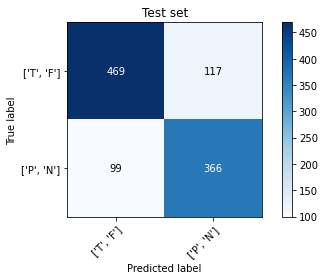

Confusion matrix: [[35 16]
 [19 61]]
Statistic       Value
-----------  --------
Accuracy     0.732824
Precision    0.792208
Recall       0.7625
F1           0.77707
MCC          0.444545
Kappa        0.44404
SE           0.7625
SP           0.686275
PPV          0.792208
NPV          0.648148
TPR          0.7625
FPR          0.313725
[[35 16]
 [19 61]]


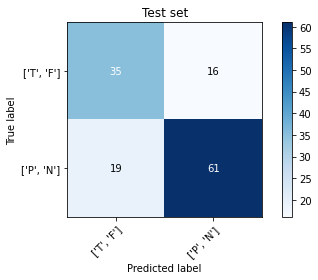

In [10]:
#Statistical characteristics of model

ml_helper.get_ML_StatsForNSplits(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
